In [1]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

In [2]:
%autoreload 2
from classes.data_wraper import Dataset
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile, apply_mask

In [3]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
channels = ['FOVfitting_2', '3quadrants_2']
dataset = Dataset(channels)

Added data from FOVfitting_2
New lenght: 297
Added data from 3quadrants_2
New lenght: 755


In [5]:
dataset.preprocess_data()
dataset.crop_data(128)

In [6]:
df = dataset.df
X = np.stack((df['map1'].to_list(), df['map2'].to_list(), df['map3'].to_list()), axis=3)
y = df['combined'].to_numpy()
azimut = df['azimut'].to_numpy()

In [8]:
model = 'UNet'

if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
    model_path = os.path.join(root_dir, model)
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")
    model_path = os.path.join(root_dir, 'models', model)

model_path_mae = model_path + '_mae'
unet = UNet(model_path=model_path_mae)

Loaded model from c:\Users\f076048\Documents\Stage_CSL\models\UNet_mae


1/1 [==============================] - 1s 614ms/step


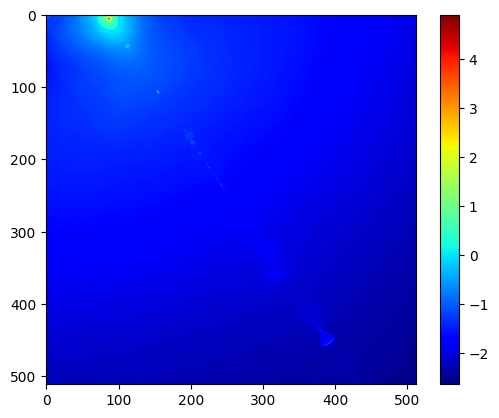

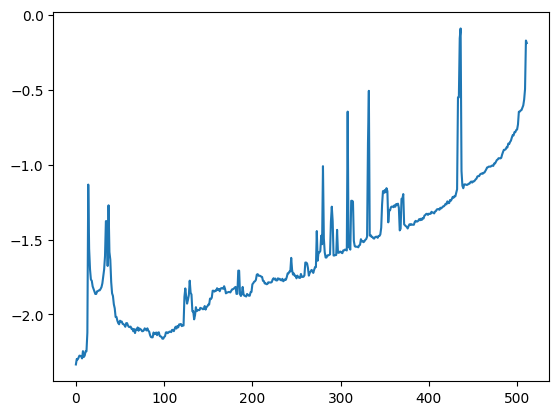

In [9]:
ind = random.randint(0, len(X)-1)
pred = unet.model.predict(X[ind:ind+1])[0, :, :, 0]
embeded = dataset.embed_map(pred, ind)
#embeded = dataset.rev_preprocess(embeded, ind)
plot_map(np.log10(embeded))
plot_radial_profile([np.log10(embeded)], azimut[ind])

In [ ]:
preds = unet.model.predict(X)

In [16]:
# compute stray light and plot stray light as a function of the x and y coordinates
sl_list = []
x_list = []
y_list = []
for i, pred in enumerate(preds):
    pred = pred[:, :, 0]
    embeded = dataset.embed_map(pred, i)
    x, y, sl = dataset.compute_stray_light(embeded)
    sl_list.append(sl)
    x_list.append(x)
    y_list.append(y)

In [13]:
# compute stray light and plot stray light as a function of the x and y coordinates
sl_list = []
x_list = []
y_list = []
for i, pred in enumerate(preds):
    x, y, sl = dataset.compute_stray_light(df['saved_combined'].to_numpy()[i])
    sl_list.append(sl)
    x_list.append(x)
    y_list.append(y)

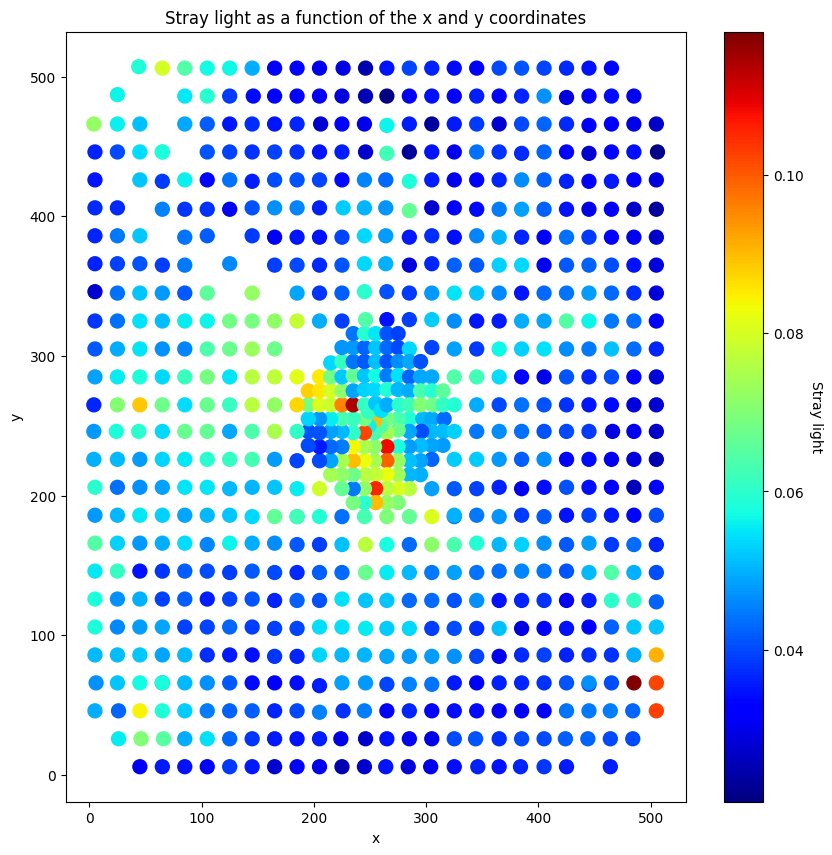

In [17]:
# scatter plot the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_list, y_list, c=sl_list, cmap='jet', s=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stray light as a function of the x and y coordinates')
# add a scaled colorbar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_ylabel('Stray light', rotation=-90, va="bottom")
plt.show()

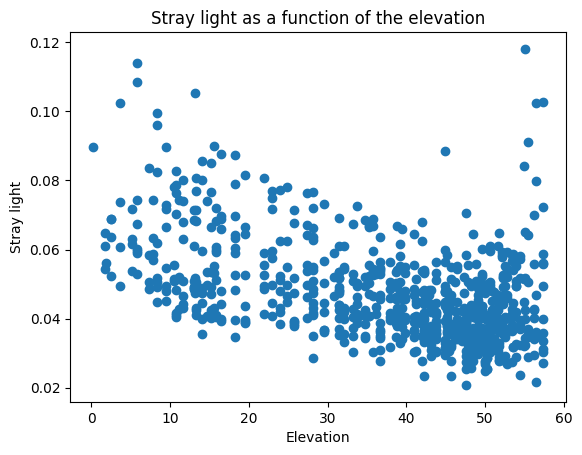

In [18]:
# plot the stray light as a function of the elevation
elevation = df['elevation'].to_numpy()
plt.plot(elevation, sl_list, 'o')
plt.xlabel('Elevation')
plt.ylabel('Stray light')
plt.title('Stray light as a function of the elevation')
plt.show()